In [1]:
import h5py
import math
import numpy as np
import torch
import importlib

from decoderSDF_rgb import DecoderSDF
from marching_cubes_rgb import *

###### parameter #####

TESTING = True

MODEL_PATH = "models_pth/decoderSDF.pth"
LATENT_VECS_PATH = "models_pth/latent_vecs.pth"

MODEL_PATH_TEST = "models_pth/decoderSDF_TEST.pth"
LATENT_VECS_PATH_TEST = "models_pth/latent_vecs_TEST.pth"

input_file = "../../data_processing/sdf_12_cars.h5"
# input_file = "../sdf/sdf_input.h5"

latent_size = 2
num_epoch = 1000
batch_size = 10000

eta_decoder = 5e-3
eta_latent_space = 1e-2

# load file
h5f = h5py.File(input_file, 'r')

sdf_data = torch.Tensor(h5f["tensor"][()])
# sdf_data = sdf_data[:2,:,:,:,:]

resolution = sdf_data.shape[1]
num_samples_per_scene = resolution * resolution * resolution
num_scenes = len(sdf_data)

assert(len(sdf_data.shape) == 5), "sdf data shoud have dimension: num_scenes x X_dim x Y_dim x Z_dim"
assert(sdf_data.shape[1] == sdf_data.shape[2] and sdf_data.shape[2] == sdf_data.shape[3]),"resolution should be the same in every direction"

#fill tensors
idx = torch.arange(num_scenes).cuda()
xyz = torch.empty(num_samples_per_scene, 3,  dtype=torch.float).cuda()

for x in range(resolution):
    for y in range(resolution):
        for z in range(resolution):
            xyz[x * resolution * resolution + y * resolution + z, :] = torch.Tensor([x/(resolution-1)-0.5,y/(resolution-1)-0.5,z/(resolution-1)-0.5])


print(torch.cuda.memory_allocated(0)/torch.cuda.memory_reserved(0))

Using skimage's marching cubes implementation.
0.187744140625


In [3]:
sdf_gt = torch.empty(sdf_data.numel(), dtype=torch.float)
rgb_gt = torch.empty([sdf_data.numel(), 3], dtype=torch.uint8)
for id in range(num_scenes):
    if id%5 == 0:
        print(id)
    for x in range(resolution):
        for y in range(resolution):
            for z in range(resolution):
                sdf_gt[id * num_samples_per_scene + x * resolution * resolution + y * resolution + z] = sdf_data[id,x,y,z,0]
                rgb_gt[id * num_samples_per_scene + x * resolution * resolution + y * resolution + z,:] = sdf_data[id,x,y,z,1:]

sdf_gt = sdf_gt.cuda()
sdf_gt = sdf_gt /resolution

rgb_gt = rgb_gt.cuda()

threshold_precision = 1
threshold_precision = threshold_precision/resolution



0


In [6]:
# initialize random latent code for every shape
lat_vecs = torch.nn.Embedding(num_scenes, latent_size).cuda()
torch.nn.init.normal_(
    lat_vecs.weight.data,
    0.0,
    1.0 / math.sqrt(latent_size),
)

# decoder
import decoderSDF_rgb
importlib.reload(decoderSDF_rgb)

decoder = decoderSDF_rgb.DecoderSDF(latent_size).cuda()

#optimizer
optimizer = torch.optim.Adam(
    [
        {
            "params": decoder.parameters(),
            "lr": eta_decoder,
        },
        {
            "params": lat_vecs.parameters(),
            "lr": eta_latent_space,
        },
    ]
)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9998)


log_loss = []
log_loss_sdf = []
log_loss_rgb = []
log_loss_reg = []

print(torch.cuda.memory_allocated(0)/torch.cuda.memory_reserved(0))

0.02772216796875


In [7]:

####################### Training loop ##########################

loss = torch.nn.MSELoss

num_epoch = 10000
batch_size = 10000

decoder.train()

for epoch in range(num_epoch):
    optimizer.zero_grad()

    #get random scene and samples
    batch_sample_idx = np.random.randint(num_samples_per_scene, size = batch_size)
    batch_scenes_idx = np.random.randint(num_scenes, size = batch_size)

    sdf_pred = decoder(lat_vecs(idx[batch_scenes_idx]), xyz[batch_sample_idx])

    # assign weight of 0 for easy samples that are well trained
    weight_sdf = ~((sdf_pred[:,0] > threshold_precision).squeeze() * (sdf_gt[batch_scenes_idx * num_samples_per_scene + batch_sample_idx] > threshold_precision).squeeze()) \
        * ~((sdf_pred[:,0] < -threshold_precision).squeeze() * (sdf_gt[batch_scenes_idx * num_samples_per_scene + batch_sample_idx] < -threshold_precision).squeeze())

    
    #L1 loss, only for hard samples
    loss_sdf = loss(reduction='none')(sdf_pred[:,0].squeeze(), sdf_gt[batch_scenes_idx * num_samples_per_scene + batch_sample_idx])
    loss_sdf = (loss_sdf * weight_sdf).mean() * weight_sdf.numel()/weight_sdf.count_nonzero()

    # loss rgb
    # lambda_rgb = min(1/10, max(0, (epoch-1000)/50000))
    lambda_rgb = 1/10
    # lambda_rgb = 0
    
    rgb_gt_normalized = rgb_gt[batch_scenes_idx * num_samples_per_scene + batch_sample_idx,:]/255
    loss_rgb = loss(reduction='none')(sdf_pred[:,1:], rgb_gt_normalized)
    loss_rgb = ((loss_rgb[:,0] * weight_sdf) + (loss_rgb[:,1] * weight_sdf) + (loss_rgb[:,2] * weight_sdf)).mean() * weight_sdf.numel()/weight_sdf.count_nonzero() * lambda_rgb
    

    #regularization loss
    lambda_reg_std = 1/1000
    lambda_reg_mean = 1/1000
    loss_reg_std = lambda_reg_std * abs(1.0 / math.sqrt(latent_size) - (lat_vecs.weight).std())
    loss_reg_mean = lambda_reg_mean * abs((lat_vecs.weight).mean())
    loss_reg = loss_reg_mean + loss_reg_std


    loss_pred = loss_sdf + loss_rgb + loss_reg_std + loss_reg_mean
    # loss_pred = loss_sdf + loss_reg_std + loss_reg_mean

    #log
    log_loss.append(loss_pred.detach().cpu())
    log_loss_sdf.append(loss_sdf.detach().cpu())
    log_loss_rgb.append(loss_rgb.detach().cpu())
    log_loss_reg.append(loss_reg.detach().cpu())

    #update weights
    loss_pred.backward()
    optimizer.step()
    scheduler.step()

    print("After {} epoch,  loss sdf: {:.5f}, loss rgb: {:.5f}, loss reg: {:.5f}, min/max sdf: {:.2f}/{:.2f}, min/max rgb: {:.2f}/{:.2f}, lr: {:f}, lat_vec mean/std: {:.2f}/{:.2f}".format(\
        epoch, torch.Tensor(log_loss_sdf[-10:]).mean(), torch.Tensor(log_loss_rgb[-10:]).mean(), torch.Tensor(log_loss_reg[-10:]).mean(), sdf_pred[:,0].min() * resolution, \
        sdf_pred[:,0].max() * resolution, sdf_pred[:,1:].min() * 255, sdf_pred[:,1:].max() * 255, optimizer.param_groups[0]['lr'], (lat_vecs.weight).std(), (lat_vecs.weight).mean()))




After 0 epoch,  loss sdf: 0.18504, loss rgb: 0.05313, loss reg: 0.00039, min/max sdf: -23.30/49.65, min/max rgb: 0.55/253.28, lr: 0.004999, lat_vec mean/std: 0.40/-0.06
After 1 epoch,  loss sdf: 0.26434, loss rgb: 0.04105, loss reg: 0.00038, min/max sdf: -43.87/218.28, min/max rgb: 0.23/208.92, lr: 0.004998, lat_vec mean/std: 0.41/-0.06
After 2 epoch,  loss sdf: 1.23538, loss rgb: 0.03683, loss reg: 0.00037, min/max sdf: -89.69/223.47, min/max rgb: 0.16/158.08, lr: 0.004997, lat_vec mean/std: 0.43/-0.06
After 3 epoch,  loss sdf: 0.96743, loss rgb: 0.03442, loss reg: 0.00037, min/max sdf: -19.80/278.93, min/max rgb: 0.14/178.13, lr: 0.004996, lat_vec mean/std: 0.44/-0.06
After 4 epoch,  loss sdf: 0.81946, loss rgb: 0.03453, loss reg: 0.00036, min/max sdf: -10.72/327.89, min/max rgb: 0.06/177.96, lr: 0.004995, lat_vec mean/std: 0.45/-0.06
After 5 epoch,  loss sdf: 0.69069, loss rgb: 0.03300, loss reg: 0.00035, min/max sdf: -2.56/405.88, min/max rgb: 0.00/198.76, lr: 0.004994, lat_vec mea

In [8]:
#save logs plot

avrg_loss = []
avrg_loss_sdf = []
avrg_loss_rgb = []
for i in range(0,len(log_loss)):
    avrg_loss.append(torch.Tensor(log_loss[i-20:i]).mean())
    avrg_loss_sdf.append(torch.Tensor(log_loss_sdf[i-20:i]).mean())
    avrg_loss_rgb.append(torch.Tensor(log_loss_rgb[i-20:i]).mean())

# import pickle
# with open("logs/log.txt", "wb") as fp:
#     pickle.dump(avrg_loss, fp)

final loss: 0.000074


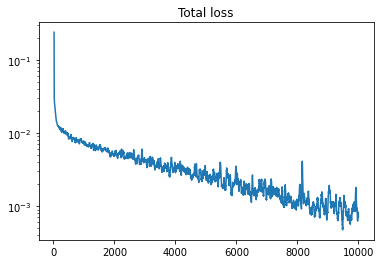

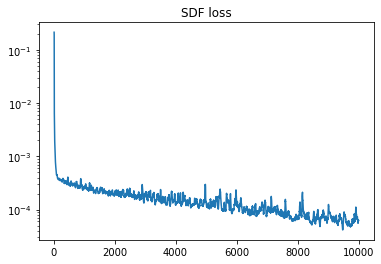

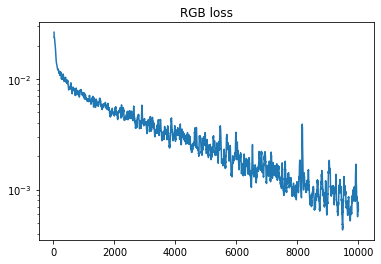

In [9]:
from matplotlib import pyplot as plt
plt.figure()
plt.title("Total loss")
plt.semilogy(avrg_loss[:])
plt.savefig("../../data_processing/logs/log_total")
plt.figure()
plt.title("SDF loss")
plt.semilogy(avrg_loss_sdf[:])
plt.savefig("../../data_processing/logs/log_sdf")
plt.figure()
plt.title("RGB loss")
plt.semilogy(avrg_loss_rgb[:])
plt.savefig("../../data_processing/logs/log_rgb")


print("final loss: {:f}".format(torch.Tensor(log_loss_sdf[-100:]).mean()))

In [10]:
############## save model ############

if (TESTING == True):
    torch.save(decoder, MODEL_PATH_TEST)
    torch.save(lat_vecs, LATENT_VECS_PATH_TEST)
else:
    torch.save(decoder, MODEL_PATH)
    torch.save(lat_vecs, LATENT_VECS_PATH)

############## load model ############

if (TESTING == True):
    decoder = torch.load(MODEL_PATH_TEST).cuda()
    lat_vecs = torch.load(LATENT_VECS_PATH_TEST).cuda()
else:
    decoder = torch.load(MODEL_PATH).cuda()
    lat_vecs = torch.load(LATENT_VECS_PATH).cuda()

sdf_output = np.empty([num_scenes , resolution, resolution, resolution, 4])

decoder.eval()
for i in range(num_scenes):
    
    # free variable for memory space
    try:
        del sdf_pred
    except:
        print("sdf_pred wasn't defined")

    # decode
    sdf_result = np.empty([resolution, resolution, resolution, 4])

    for x in range(resolution):
        
        sdf_pred = decoder(lat_vecs(idx[i].repeat(resolution * resolution)),xyz[x * resolution * resolution: (x+1) * resolution * resolution])

        sdf_pred[:,0] = sdf_pred[:,0] * resolution
        sdf_pred[:,1:] = torch.clamp(sdf_pred[:,1:], 0, 1)
        sdf_pred[:,1:] = sdf_pred[:,1:] * 255

        for y in range(resolution):
            for z in range(resolution):
                sdf_result[x,y,z,:] = sdf_pred[y * resolution + z,:].detach().cpu()

    sdf_output[i] = sdf_result

    print('Minimum and maximum value: %f and %f. ' % (np.min(sdf_result[:,:,:,0]), np.max(sdf_result[:,:,:,0])))
    if(np.min(sdf_result[:,:,:,0]) < 0 and np.max(sdf_result[:,:,:,0]) > 0):
        vertices, faces = marching_cubes(sdf_result[:,:,:,0])
        colors_v = exctract_colors_v(vertices, sdf_result)
        colors_f = exctract_colors_f(colors_v, faces)
        off_file = '../../data_processing/output_prediction/%d.off' % i
        write_off(off_file, vertices, faces, colors_f)
        print('Wrote %s.' % off_file)
    else:
        print("surface level: 0, should be comprise in between the minimum and maximum value")



Minimum and maximum value: -1.819474 and 1690.098145. 
Wrote ../../data_processing/output_prediction/0.off.


/home/loic/MasterPDM/codePDM/ML/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)


In [50]:
# num_interp = 10
# id_car_A = 0
# id_car_B = 1

# decoder.eval()
# for i in range(num_interp):
#     # interp_late_vecs = (i/(num_interp-1) * lat_vecs(idx[id_car_A]) + (1 - i/(num_interp-1)) * lat_vecs(idx[id_car_B])).repeat(num_samples_per_scene,1)
#     interp_late_vecs = (i/(num_interp-1) * lat_vecs(idx[id_car_A]) + (1 - i/(num_interp-1)) * lat_vecs(idx[id_car_B])).repeat(resolution * resolution,1)
    
#     # free variable for memory space
#     try:
#         del sdf_pred
#     except:
#         print("sdf_pred wasn't defined")

#     # decode
#     # sdf_pred = decoder(interp_late_vecs,xyz)
    
#     # sdf_pred[:,0] = sdf_pred[:,0] * resolution
#     # sdf_pred[:,1:] = torch.clamp(sdf_pred[:,1:], 0, 1)
#     # sdf_pred[:,1:] = sdf_pred[:,1:] * 255

#     sdf_result = np.empty([resolution, resolution, resolution, 4])

#     for x in range(resolution):

#         sdf_pred = decoder(interp_late_vecs,xyz[x * resolution * resolution: (x+1) * resolution * resolution])
#         sdf_pred[:,0] = sdf_pred[:,0] * resolution
#         sdf_pred[:,1:] = torch.clamp(sdf_pred[:,1:], 0, 1)
#         sdf_pred[:,1:] = sdf_pred[:,1:] * 255

#         for y in range(resolution):
#             for z in range(resolution):
#                 sdf_result[x,y,z,:] = sdf_pred[y * resolution + z,:].detach().cpu()
#                 # sdf_result[x,y,z,:] = sdf_pred[x * resolution * resolution + y * resolution + z,:].detach().cpu()

#     print('Minimum and maximum value: %f and %f. ' % (np.min(sdf_result[:,:,:,0]), np.max(sdf_result[:,:,:,0])))
#     if(np.min(sdf_result[:,:,:,0]) < 0 and np.max(sdf_result[:,:,:,0]) > 0):
#         vertices, faces = marching_cubes(sdf_result[:,:,:,0])
#         colors_v = exctract_colors_v(vertices, sdf_result)
#         colors_f = exctract_colors_f(colors_v, faces)
#         off_file = '../../data_processing/output_interpolation/%d.off' % i
#         write_off(off_file, vertices, faces, colors_f)
#         print('Wrote %s.' % off_file)
#     else:
#         print("surface level: 0, should be comprise in between the minimum and maximum value")

Minimum and maximum value: -3.179944 and 26.584064. 


/home/loic/masterPDM_0/ML/rgb/marching_cubes_rgb.py:100: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, faces, normals, values = measure.marching_cubes_lewiner(tensor.transpose(1, 0, 2), 0)


Wrote output/interpolation/0.off.
Minimum and maximum value: -2.736576 and 26.447989. 
Wrote output/interpolation/1.off.
Minimum and maximum value: -3.062799 and 26.168612. 
Wrote output/interpolation/2.off.
Minimum and maximum value: -3.481607 and 29.564978. 
Wrote output/interpolation/3.off.
Minimum and maximum value: -3.304924 and 32.617123. 
Wrote output/interpolation/4.off.
Minimum and maximum value: -3.178566 and 38.145210. 
Wrote output/interpolation/5.off.
Minimum and maximum value: -3.342341 and 42.483875. 
Wrote output/interpolation/6.off.
Minimum and maximum value: -3.544979 and 47.362499. 
Wrote output/interpolation/7.off.
Minimum and maximum value: -4.007718 and 53.244766. 
Wrote output/interpolation/8.off.
Minimum and maximum value: -3.823768 and 56.872467. 
Wrote output/interpolation/9.off.
